# Multi-Taxi Environment

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CLAIR-LAB-TECHNION/multi-taxi/blob/main/notebooks/MultiTaxiEnvDemo.ipynb)

Welcome to `multi-taxi`, a highly versatile and configurable multi-agent environment for testing AI algorithms. It allows the user to customize the problem with granular control on a per-agent basis, including:
* the number of taxis and passengers in the environment (limited to the size of the map)
* the domain map itself
* the environment objective
* individual taxi configurations, e.g.:
   * reward function
   * action and observation space
   * passenger and fuel capacity
* and so much more!

This notebook demonstrates the capabilities of this environment, including its many options, configurations, and addons.

## Quickstart
First thing's first... Let's install the latest stable version of the environment.

Now, let us begin with a quick example. Below, we instantiate a `multi_taxi` environment with 2 taxis and 3 passengers, where taxi_0 can carry up to 1 passenger at a time and has 30 steps-worth of fuel, and taxi_1 can carry up to 2 passengers at a time and has an infinite amount of fuel. Both taxis can use the "standby" action, but only taxi_0 can control the engine status (on/off). The environment map is a pre-defined hourglass-shaped map.

In [1]:
from multi_taxi import multi_taxi_v0, maps, FuelType

# using the default PettingZoo API here
env = multi_taxi_v0.env(
    num_taxis=2,                       # there are 2 active taxis (agents) in the environment
    num_passengers=3,                  # there are 3 passengers in the environment
    max_capacity=[1, 2],               # taxi_0 can carry 1 passenger, taxi_1 can carry 2
    max_fuel=[30, None],               # taxi_0 has a 30 step fuel limit, taxi1 has infinite fuel
    fuel_type=FuelType.GAS,            # taxis can only refuel at gas stations, marked "G" (only affects taxi_0)
    has_standby_action=True,           # all taxis can perform the standby action
    has_engine_control=[True, False],  # taxi_0 has engine control actions, taxi_1 does not
    domain_map=maps.HOURGLASS,         # the environment map is the pre-defined HOURGLASS map
    render_mode='human'  # MUST SPECIFY RENDER MODE TO ENABLE RENDERING
)
env.reset(seed=42)
env.render()

+-----------------------+
| : |F: | :D| : | : |G:D|
| : : : : : | : : : : : |
|X:X:X:X: :P: : :X:X:X:X|
|X:X:X:X: : | :D:X:X:X:X|
|X:X:X:X: : | : :X:X:X:X|
| : : : : : : : : : : : |
| | :G|P| | :F| | | :P| |
+-----------------------+
Taxi0-YELLOW: Fuel: 30/30, Location: (0, 5), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: inf, Location: (5, 10), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (6, 3), Destination: (0, 11)
Passenger1-RED: Location: (6, 10), Destination: (0, 5)
Passenger2-WHITE: Location: (2, 5), Destination: (3, 7)
Env done: False



Above we can see a rendering of the environment. The rectangles are taxis and the colorful P's and D's are the passengers and their respective desired destinations. Taxis can navigate within the map, but cannot occupy blocked cells ("X" character), and cannot cross horizontally between cells separated by a wall ("|" character). The map also consists of two types of fuel stations, marked "F" (for "Fuel") and "G" (for "Gas") at which the taxis can refuel, but only if they require the correct type of fuel. The objective is to pick up all passengers and drop them off at their desired destinations. We do this using the [PettingZoo](https://www.pettingzoo.ml/) API to perform actions for each taxi.

In [2]:
import time
from IPython.display import clear_output

# a solution based on the current action spaces of both taxis.
# see "Actions" section to understand action index meanings.
solution = {'taxi_0': [0, 0, 4, 2, 2, 0, 5, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
                       6, 6, 6, 6, 6, 6, 6, 6, 6],
            'taxi_1': [0, 4, 1, 3, 3, 3, 3, 3, 3, 3, 0, 4, 1, 2, 2, 1, 1, 1, 1, 1, 5, 0, 0,
                       2, 1, 2, 2, 2, 2, 2, 1, 5]}

env.reset(seed=42)
env.render()
for agent in env.agent_iter():
    observation, reward, term, trunc, info = env.last()

    if term:
        print('success!')
        break
    if trunc:
        print('truncated')
        break

    if not solution[env.agent_selection]:  # check solution complete without done
        print('failure')
        break

    # get next action from predefined solution
    action = solution[env.agent_selection].pop(0)
    env.step(action)

    # re-render after step
    if  agent == env.possible_agents[-1]:
        # state only changes after both taxis have stepped
        time.sleep(0.15)  # sleep for animation speed control
        clear_output(wait=True)  # clear previous render for animation effect
        env.render()

+-----------------------+
| : |F: | : | : | : |G: |
| : : : : : | : : : : : |
|X:X:X:X: : : : :X:X:X:X|
|X:X:X:X: : | : :X:X:X:X|
|X:X:X:X: : | : :X:X:X:X|
| : : : : : : : : : : : |
| | :G| | | :F| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 18/30, Location: (3, 7), Engine: OFF, Collided: False, Step: 32, ALIVE
Taxi1-RED: Fuel: inf, Location: (0, 11), Engine: ON, Collided: False, Step: 32, ALIVE
Passenger0-YELLOW: Location: (0, 11), Destination: Arrived! (0, 11)
Passenger1-RED: Location: (0, 5), Destination: Arrived! (0, 5)
Passenger2-WHITE: Location: (3, 7), Destination: Arrived! (3, 7)
Env done: True

success!


In the above example, taxi_0 (yellow) takes passenger 2 to its destination and then has nothing left to contribute, so it turns off its engine and does nothing until the end of the episode. taxi_1 (red) takes advantage of its size 2 capacity to carry both passengers 0 and 1 simultaneously, thus conserving cumulative time in their journeys to their destinations.

`multi-taxi` also naturally supports PettingZoo's parallel API. Let us run the same example below using this API.

In [3]:
# using the PettingZoo parallel API here
par_env = multi_taxi_v0.parallel_env(
    num_taxis=2,
    num_passengers=3,
    max_capacity=[1, 2],
    max_fuel=[30, None],
    fuel_type=FuelType.GAS,
    has_standby_action=True,
    has_engine_control=[True, False],
    domain_map=maps.HOURGLASS,
    render_mode='human'
)

# exact same solution from the previous example
solution = {'taxi_0': [0, 0, 4, 2, 2, 0, 5, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
                       6, 6, 6, 6, 6, 6, 6, 6, 6],
            'taxi_1': [0, 4, 1, 3, 3, 3, 3, 3, 3, 3, 0, 4, 1, 2, 2, 1, 1, 1, 1, 1, 5, 0, 0,
                       2, 1, 2, 2, 2, 2, 2, 1, 5]}


# parallel API initial observation given on reset
# this is a dictionary of observations, with agent names as keys
observations = par_env.reset(seed=42)
par_env.render()
while True:
    if any(not sol for sol in solution.values()):  # check solution complete without done
        print('failure')
        break

    # arange next action as a joint action to be executed in parallel for all agents
    joint_action = {agent: solution[agent].pop(0) for agent in par_env.agents}

    # parallel API gets next observations, rewards, terms, truncs, and infos upon `step`
    # all values are dictionaries
    observations, rewards, terms, truncs, infos = par_env.step(joint_action)

    # re-render after step
    time.sleep(0.15)  # sleep for animation speed control
    clear_output(wait=True)
    par_env.render()  # clear previous render for animation effect

    if any(terms.values()):  # check dones
        print('success!')
        break
    if all(truncs.values()):
        print('truncated')
        break


+-----------------------+
| : |F: | : | : | : |G: |
| : : : : : | : : : : : |
|X:X:X:X: : : : :X:X:X:X|
|X:X:X:X: : | : :X:X:X:X|
|X:X:X:X: : | : :X:X:X:X|
| : : : : : : : : : : : |
| | :G| | | :F| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 18/30, Location: (3, 7), Engine: OFF, Collided: False, Step: 32, ALIVE
Taxi1-RED: Fuel: inf, Location: (0, 11), Engine: ON, Collided: False, Step: 32, ALIVE
Passenger0-YELLOW: Location: (0, 11), Destination: Arrived! (0, 11)
Passenger1-RED: Location: (0, 5), Destination: Arrived! (0, 5)
Passenger2-WHITE: Location: (3, 7), Destination: Arrived! (3, 7)
Env done: True

success!


The environment objective can be simplified by setting the parameter `pickup_only` to `True`. When this is the case, passenger destinations and taxi capacities are ignored, and once all passengers have been picked up, the environment task is complete and the agents are done.

In [4]:
pickup_only_env = multi_taxi_v0.env(
    num_taxis=2,
    num_passengers=3,
    max_capacity=[1, 2],
    max_fuel=[30, None],
    has_standby_action=True,
    has_engine_control=[True, False],
    domain_map=maps.HOURGLASS,
    pickup_only=True, # SET PICKUP ONLY FOR EASIER OBJECTIVE
    render_mode='human'
)

# new solution tailored for the pickup only objective
solution = {'taxi_0': [0, 0, 4, 0, 0, 0, 3, 3, 0, 4],
            'taxi_1': [0, 4, 5, 5, 5, 5, 5, 5, 5, 5]}


pickup_only_env.reset(seed=42)
pickup_only_env.render()
for agent in pickup_only_env.agent_iter():

    # observation, reward, term, trunc, and info given one by one via the `last` method
    observation, reward, term, trunc, info = pickup_only_env.last()

    if term:  # check done status
        print('success!')
        break
    if trunc:
        print('truncated')
        break

    if not solution[pickup_only_env.agent_selection]:  # check solution complete without done
        print('failure')
        break

    # get next action from predefined solution
    action = solution[pickup_only_env.agent_selection].pop(0)
    pickup_only_env.step(action)

    # re-render after step
    if  agent == pickup_only_env.possible_agents[-1]:
        # state only changes after both taxis have stepped
        time.sleep(0.15)  # sleep for animation speed control
        clear_output(wait=True)  # clear previous render for animation effect
        pickup_only_env.render()

+-----------------------+
| : |F: | : | : | : |G: |
| : : : : : | : : : : : |
|X:X:X:X: : : : :X:X:X:X|
|X:X:X:X: : | : :X:X:X:X|
|X:X:X:X: : | : :X:X:X:X|
| : : : : : : : : : : : |
| | :G| | | :F| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 12/30, Location: (6, 3), Engine: ON, Collided: False, Step: 10, ALIVE
Taxi1-RED: Fuel: inf, Location: (6, 10), Engine: ON, Collided: False, Step: 10, ALIVE
Passenger0-YELLOW: Location: Taxi0 (6, 3), Destination: (-1, -1)
Passenger1-RED: Location: Taxi1 (6, 10), Destination: (-1, -1)
Passenger2-WHITE: Location: Taxi0 (6, 3), Destination: (-1, -1)
Env done: True

success!


## Environment Parameters
As was previously mentioned, this environment is highly configurable. There are two types of environment configuration parameters: Environment configurations and Taxi configurations. Below is a list of these parameters:

Environment configurations:
* `num_taxis`: the number of taxis operating in the environment.
* `num_passengers`: the number of passengers to drive in the environment.
* `domain_map`: array of strings representing the environment map with special characters for taxis initialized spots and fuel stations(see `multi_taxi.world.maps.DEFAULT_MAP`).
* `pickup_only`: simplifies the problem to only pick up all passengers, without needing dropping them off.
* `pickup_order`: a list of passenger IDs (zero-indexed) that enforces the order in which these passengers can be picked up. Passengers not included in the list may be picked up at any time. For example, if we have 3 passengers and a pickup order of \[1, 0\], then passenger 0 can only be picked up after passenger 1 has been picked up, and passenger 2 can be picked up regardless of any other passenger's status.
* `dropoff_order`: a list of passenger IDs (zero-indexed) that enforces the order in which these passengers can be dropped off at their destination. Passengers not included in the list may be dropped off at their destination at any time. For example, if we have 3 passengers and a dropoff order of \[1, 0\], then passenger 0 can only be delivered at its destination after passenger 1 has been delivered, and passenger 3 can be delivered regardless of any other passenger's status.
* `intermediate_dropoff_reward_by_distance`: changes the reward function for dropping off passengers at a location that is not their final destination. if `True`, the given reward for intermediate dropoffs is the negative Manhattan distance from the dropoff location and the passenger's true destination. otherwise, the given reward is that of the taxi's reward table.
* `distinct_taxi_initial_locations`: asserts distinct start locations for taxis on reset.
* `distinct_passenger_initial_pickups`: asserts distinct start locations for passengers on reset.
* `distinct_passenger_dropoffs`: asserts distinct passenger destinations on reset.
* `allow_collided_taxis_on_reset`: if `True`, taxis may start at the same location and are considered to be collided.
* `allow_arrived_passengers_on_reset`: if `True`, passengers may start at the same location as their destination and are considered to have arrived.
* `clear_dead_taxis`: if `True`, taxis that can no longer act (i.e. dead) are completely removed from the environment. otherwise, dead taxis remain in the environment, continue receiving rewards, and can be collided into.
* `initial_seed`: sets deterministic randomness in the environment. can be overriden at any time using the `seed` method, or by providing a `seed` parameter to the `reset` method.
* `render_mode`: set this parameter to control the type of environment rendering. can be 'human', 'ansi', or 'rgb_arry'. if not provided, no rendering is available (calling `render` will emmit a warning).

Taxi Configurations:
* `max_steps`: determines the maximum number of actions a taxi can take at each reset.
* `max_capacity`: determines a taxi's maximum passenger capacity.
* `max_fuel`: determines a taxi's maximum fuel capacity
* `fuel_type`: determines a taxi's required fuel station for refueling
* `has_standby_action`: if `True`, the taxi has the ability to perform the "standby" action, i.e., do nothing.
* `has_engine_control`: if `True`, the taxi can turn the engine on and off.
* `engine_off_on_empty_tank`: if `True`, if the taxi runs out of fuel and does not refuel at that step, the taxi's engine will turn off. This parameter is ignored if the taxi does not have engine control.
* `can_refuel_on_empty`: if `False`, a taxi is considered dead when its fuel capacity reaches 0. if `True`, a taxi with 0 fuel may still act if it is on a valid fuel station.
* `can_collide`: if `True`, the taxi becomes a collidable and may collide with other collidable taxis.
* `passenger_fumble`: if `True`, all carried passengers are dropped off when the taxi dies at the location of the taxi's death.
* `specify_passenger_pickup`: if `True`, the taxi's "pickup" actions must indicate the exact passenger they intend to pick up. otherwise, a generic pickup action is used.
* `specify_passenger_dropoff`: if `True`, the taxi's "dropoff" actions must indicate the exact passenger they intend to drop off. otherwise, a generic dropoff action is used.
* `reward_table`: a dictionary that describes the taxi's reward function upon the occurrence of certain events (see `multi_taxi.utils.types.Event`).
* `stochastic_actions`: a dictionary that describes a taxi's probabilities to perform different actions than the intended one.
* `observation_type`: determines the type of observations received for the taxi.
* `can_see_other_taxi_info`: adds information for other taxis into symbolic observations. ignored when image observations are used.
* `field_of_view`: defines the dimension of the square window around the taxi within the domain map for image observations. if not specified, the image observation is the entire map.

Environment configurations must be a single value of a specific type, while taxi configurations are either a value of a specific type or a list of values of that type which is the same length as the number of taxis in the environment. Taxi configurations that are given as a single value will be used for all taxis. Any configuration, including specific taxi configurations (i.e., values within a given list of configurations) may be replaced with `None` to use the default configuration. Configuration defaults can be found in `multi_taxi.env.config`.

Throughout this notebook, we will explore what these configurations mean and what combinations are possible (hitn: most combinations are possible).

## Observations

Observations can be divided into 2 categories: "symbolic vectors" and "images". By default, taxis receive symbolic observations tailored to their given or default configurations. The PettingZoo API enables us to view the agents' observation spaces individually. Let us try this on our previously created environment.

In [5]:
t0_ospace = env.observation_space('taxi_0')
print(f'taxi_0\'s observation space is a vector of \x1b[1m{len(t0_ospace)}\x1b[0m discrete values')
t0_ospace

taxi_0's observation space is a vector of 26 discrete values


MultiDiscrete([ 7 12 31  2  2  7 12  7 12  2  2  2  7 12  7 12  2  2  2  7 12  7 12  2
  2  2])

In [6]:
t1_ospace = env.observation_space('taxi_1')
print(f'taxi_1\'s observation space is a vector of \x1b[1m{len(t1_ospace)}\x1b[0m discrete values')
t1_ospace

taxi_1's observation space is a vector of 23 discrete values


MultiDiscrete([ 7 12  7 12  7 12  2  2  2  7 12  7 12  2  2  2  7 12  7 12  2  2  2])

As we can see, since both taxis are configured differently, they receive unique observations of different dimensions and overall meanings. For example, taxi_0 has a fuel limit, and thus receives information on its remaining fuel at index 2 (third from the left) of the observation vector.

### Symbolic Observations

Symbolic observations are simply vectors with discrete values that describe the environment. There are 17 different kinds of values, some of which may be repeating (e.g., multiple taxi locations), and they can appear in various combinations. Like we saw for our previously created environment, this is a very messy vector, and it can take a long time to understand what each value represents. For user convenience, we have added an additional API function `get_observation_meanings` that shows us exactly that. Let us see how we can use it (this time with the parallel environment, just to show that it doesn't matter).

In [7]:
# This is multi-taxi specific API and can only be accessed by unwrapping all wrappers.
par_env.unwrapped.get_observation_meanings('taxi_0')

['location_row',
 'location_col',
 'remaining_fuel',
 'engine_on',
 'is_dead',
 'passenger_0_location_row',
 'passenger_0_location_col',
 'passenger_0_destination_row',
 'passenger_0_destination_col',
 'passenger_0_arrived',
 'passenger_0_in_taxi_0',
 'passenger_0_in_taxi_1',
 'passenger_1_location_row',
 'passenger_1_location_col',
 'passenger_1_destination_row',
 'passenger_1_destination_col',
 'passenger_1_arrived',
 'passenger_1_in_taxi_0',
 'passenger_1_in_taxi_1',
 'passenger_2_location_row',
 'passenger_2_location_col',
 'passenger_2_destination_row',
 'passenger_2_destination_col',
 'passenger_2_arrived',
 'passenger_2_in_taxi_0',
 'passenger_2_in_taxi_1']

In [8]:
par_env.unwrapped.get_observation_meanings('taxi_1')

['location_row',
 'location_col',
 'passenger_0_location_row',
 'passenger_0_location_col',
 'passenger_0_destination_row',
 'passenger_0_destination_col',
 'passenger_0_arrived',
 'passenger_0_in_taxi_0',
 'passenger_0_in_taxi_1',
 'passenger_1_location_row',
 'passenger_1_location_col',
 'passenger_1_destination_row',
 'passenger_1_destination_col',
 'passenger_1_arrived',
 'passenger_1_in_taxi_0',
 'passenger_1_in_taxi_1',
 'passenger_2_location_row',
 'passenger_2_location_col',
 'passenger_2_destination_row',
 'passenger_2_destination_col',
 'passenger_2_arrived',
 'passenger_2_in_taxi_0',
 'passenger_2_in_taxi_1']

In [9]:
obs_space_diff = (set(par_env.unwrapped.get_observation_meanings('taxi_0')) -
                  set(par_env.unwrapped.get_observation_meanings('taxi_1')))
print('observation space difference', obs_space_diff)

observation space difference {'remaining_fuel', 'engine_on', 'is_dead'}


We can see in the above outputs that taxi_0 receives 3 additional inputs over taxi_1:
1. remaining_fuel - because it has a fuel limit, which taxi_1 does not.
2. engine_on - because it has engine control, and taxi_1 does not (engine will remain on at all times).
3. is_dead - since the taxi can die if it runs out of fuel and is not at a correct fuel station.

Therea are many more configurations that directly affect the structure of the taxi's symbolic input. For example, `can_see_other_taxi_info` will reveal all other taxi's locations and any other important taxi information if relevant (fuel, engine status, etc.). This can get very complicated very fast. However, whenever users want to understand the meaning behind the values in the observations, `get_observation_meanings` is at their disposal. For a full list of possible symbolic observation types, see the enum `multi_taxi.utils.types.SymbolicObservation`.

Finally, below is an example of an actual observation.

In [10]:
obs = par_env.reset()
obs['taxi_0']

array([ 1,  4, 30,  1,  0,  0,  2,  6,  2,  0,  0,  0,  6,  2,  0,  3,  0,
        0,  0,  6,  9,  1,  4,  0,  0,  0])

### Image Observations

If highly versitile and configurable vector input is not enough, this domain also supports RGB image observations. As we have already seen, the environment is rendered as ANSI text, but with the look of an old-school viedo game. We can provide this input as an image by rendering the text in real-time and providing these renderings as observations from the environment. Let's start by creating an environment where taxis receive image input.

In [11]:
from multi_taxi import ObservationType

# use parallel API for simultaneous access to all observations
img_par_env = multi_taxi_v0.parallel_env(
    num_taxis=3,
    num_passengers=5,
    domain_map=maps.BIG_MAP,
    observation_type=ObservationType.IMAGE,
    field_of_view=[None, 3, 10],
    render_mode='human'
)
obs = img_par_env.reset()
img_par_env.render()

+-----------------------------------+
|X:F: | : : : : : | : | : : : : : : |
|X:X: | : : | : :P| : | : : :X:X: : |
| : : | : : | : : | :D| : : :X:X:G: |
|P: : : : : |P: : | :X| : : : : : : |
| : : : : : : : :G:F: : :D: : : | : |
| : |X:X:X: : : : :D: : : : : : : : |
| :D| : : : : : :X:X:P: : : : : |F: |
| : | : : : : :X:X:X:X: : | : : : : |
| : :F: : | : : : : : : : | : :G| : |
| : | : :P| : :X:X:X:X: : : :D: : : |
+-----------------------------------+
Taxi0-YELLOW: Fuel: inf, Location: (7, 14), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: inf, Location: (3, 1), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi2-WHITE: Fuel: inf, Location: (7, 11), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (3, 6), Destination: (6, 1)
Passenger1-RED: Location: (3, 0), Destination: (4, 12)
Passenger2-WHITE: Location: (6, 10), Destination: (9, 14)
Passenger3-GREEN: Location: (1, 8), Destination: (2, 10)
Passenger4-CYAN: Location: (9, 4), Destination: (5, 9)
Env

We can view the observations in the notebook by using the below helper function to convert the observation numpy array into a PIL.Image object.

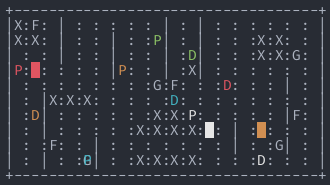

In [12]:
from PIL import Image
def np_to_pil(img_arr):
    return Image.fromarray(img_arr)

np_to_pil(obs['taxi_0'])

#### Field of View

The `field_of_view` parameter controls the range of visibility of the agent around its current position. In the above example observation of taxi_0, we can see that the taxi receives the entire map status as input. We can use this parameter to trim a square window around the observing taxi, so as to mimic some sort of limmited view. The image is cropped such that the number of cells visible in each direction of the agent matches `field_of_view`. Let's take a look at the observation of taxi_1 with `field_of_view=3` and taxi_2 with `field_of_view=10`.

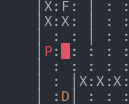

In [13]:
np_to_pil(obs['taxi_1'])

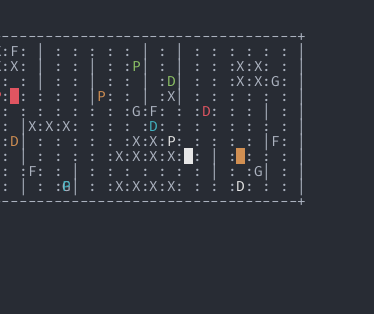

In [14]:
np_to_pil(obs['taxi_2'])

A couple of notes on image observations:
1. Image observations are limitted due to the limitations of ANSI text. That is, while the number of taxis is limited only by the size of the map (unless `distinct_taxi_initial_locations=False`, in which case there is no limit!!), the number of colors that ANSI text can show is very little. The maximum number of uniquely colored taxis and passengers/destinations is 7, and so multiple taxis in the rendering may have the same color if this number is surpassed, which may lead to ambiguity when using image input, especially with full map view.
2. The current implementation of ANSI to image rendering is quite inneficient. We are open to any and all suggestions from those who have a more efficient implementation and would like to share it. Please contact us via the github repository.

### Mixed Observations

There is still more! You don't have to choose between symbolic and image input... You can use BOTH! By choosing the MIXED observation type, a taxi will receive a dictionary of observations. Let us see an example below where all 3 taxis have different types of observations spaces, all for which we can get their meanings using `get_observation_meanings`.

In [15]:
multi_obs_env = multi_taxi_v0.parallel_env(
    # NO MAP PROVIDED THIS TIME. use the default map
    num_taxis=3,
    num_passengers=5,
    max_fuel=[30, 50, None],
    observation_type=["symbolic", "image", "mixed"],  # can use the enum's string values instead of the enum value!!!
    can_see_other_taxi_info=True,
    field_of_view=[0, 10, None]  # FOV ignored for symbolic input
)

obs = multi_obs_env.reset()

In [16]:
multi_obs_env.observation_space('taxi_0'), multi_obs_env.unwrapped.get_observation_meanings('taxi_0')

(MultiDiscrete([ 7 12 31  2  7 12 51  2  7 12  7 12  7 12  2  2  2  2  7 12  7 12  2  2
   2  2  7 12  7 12  2  2  2  2  7 12  7 12  2  2  2  2  7 12  7 12  2  2
   2  2]),
 ['location_row',
  'location_col',
  'remaining_fuel',
  'is_dead',
  'taxi_1_location_row',
  'taxi_1_location_col',
  'taxi_1_remaining_fuel',
  'taxi_1_is_dead',
  'taxi_2_location_row',
  'taxi_2_location_col',
  'passenger_0_location_row',
  'passenger_0_location_col',
  'passenger_0_destination_row',
  'passenger_0_destination_col',
  'passenger_0_arrived',
  'passenger_0_in_taxi_0',
  'passenger_0_in_taxi_1',
  'passenger_0_in_taxi_2',
  'passenger_1_location_row',
  'passenger_1_location_col',
  'passenger_1_destination_row',
  'passenger_1_destination_col',
  'passenger_1_arrived',
  'passenger_1_in_taxi_0',
  'passenger_1_in_taxi_1',
  'passenger_1_in_taxi_2',
  'passenger_2_location_row',
  'passenger_2_location_col',
  'passenger_2_destination_row',
  'passenger_2_destination_col',
  'passenger_2_arrive

In [17]:
multi_obs_env.observation_space('taxi_1'), multi_obs_env.unwrapped.get_observation_meanings('taxi_1')

(Box(0, 255, (314, 373, 3), uint8), '314x373 RGB image')

In [18]:
multi_obs_env.observation_space('taxi_2'), multi_obs_env.unwrapped.get_observation_meanings('taxi_2')

(Dict('image': Box(0, 255, (140, 226, 3), uint8), 'symbolic': MultiDiscrete([ 7 12  7 12 31  2  7 12 51  2  7 12  7 12  2  2  2  2  7 12  7 12  2  2
   2  2  7 12  7 12  2  2  2  2  7 12  7 12  2  2  2  2  7 12  7 12  2  2
   2  2])),
 {'symbolic': ['location_row',
   'location_col',
   'taxi_0_location_row',
   'taxi_0_location_col',
   'taxi_0_remaining_fuel',
   'taxi_0_is_dead',
   'taxi_1_location_row',
   'taxi_1_location_col',
   'taxi_1_remaining_fuel',
   'taxi_1_is_dead',
   'passenger_0_location_row',
   'passenger_0_location_col',
   'passenger_0_destination_row',
   'passenger_0_destination_col',
   'passenger_0_arrived',
   'passenger_0_in_taxi_0',
   'passenger_0_in_taxi_1',
   'passenger_0_in_taxi_2',
   'passenger_1_location_row',
   'passenger_1_location_col',
   'passenger_1_destination_row',
   'passenger_1_destination_col',
   'passenger_1_arrived',
   'passenger_1_in_taxi_0',
   'passenger_1_in_taxi_1',
   'passenger_1_in_taxi_2',
   'passenger_2_location_row',
  

In [19]:
obs['taxi_2'][ObservationType.SYMBOLIC.value]

array([ 5,  1,  0,  0, 30,  0,  0, 10, 50,  0,  4,  8,  0, 10,  0,  0,  0,
        0,  4,  2,  2,  6,  0,  0,  0,  0,  3,  0,  0,  5,  0,  0,  0,  0,
        3,  2,  5,  1,  0,  0,  0,  0,  1, 11,  6,  7,  0,  0,  0,  0])

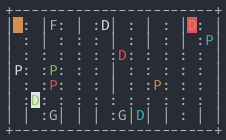

In [20]:
np_to_pil(obs['taxi_2'][ObservationType.IMAGE.value])

## Actions

All action spaces are a finite set of discrete values. However, just like observations, action spaces may still differ in size between taxis. In our quickstart example, we already saw that one taxi can have additional engine control and standby actions. This too can get quite complex, and so we provide the `get_aciton_meanings` method, similar to the observations.

In [21]:
env.action_space('taxi_0'), env.unwrapped.get_action_meanings('taxi_0')

(Discrete(10),
 {0: 'south',
  1: 'north',
  2: 'east',
  3: 'west',
  4: 'pickup',
  5: 'dropoff',
  6: 'standby',
  7: 'engine_on',
  8: 'engine_off',
  9: 'refuel'})

In [22]:
env.action_space('taxi_1'), env.unwrapped.get_action_meanings('taxi_1')

(Discrete(7),
 {0: 'south',
  1: 'north',
  2: 'east',
  3: 'west',
  4: 'pickup',
  5: 'dropoff',
  6: 'standby'})

The environment also provides an inverse of this mapping to allow easy action choosing. For example, if we wanted to choose the `dropoff` action for taxi_1, we could easily consult this mapping.

In [23]:
from multi_taxi import Action

env.unwrapped.get_action_map('taxi_1')[Action.DROPOFF.value]

5

A full list of action types is available in the `multi_taxi.utils.types.Action` enum.

### Generic Pickup and Dropoff
A noteworthy set of actions is our versatile "pickup" and "dropoff" actions. As can be seen above, our quickstart environment has a single "pickup" action, and a single "dropoff" action. But what happens if two passengers occupy the same space when being picked up? Who does the taxi drop off if it is carrying multiple passengers? The generic "pickup" and "dropoff" rules are very simple and intuitive:
* pickup - generic pickup will pick up any passenger at the taxi's current location. if multiple passengers meet this criterion, the passenger with the lowest ID is picked up.
* dropoff - generic dropoff will drop off the passenger whose destination is at the taxi's current location. if multiple passengers meet this criterion, the one with the lowest ID is dropped off. if no passenger meets this criterion, the passenger in the taxi with the lowest ID is dropped off.

### Specific Pickup and Dropoff
The reason the above example is using the generic versions of pickup and dropoff is because, by default, the `specify_passenger_pickup` and `specify_passenger_dropoff` parameters are set to `False`. Setting them to `True` will change the observation space to provide a pickup and/or dropoff action for each passenger by index.

In [24]:
# taxi_0 must specify pickup
# taxi_1 must specify dropoff
# taxi_2 must specify both pickup and dropoff
specific_pickup_and_dropoff_env = multi_taxi_v0.env(
    num_taxis=3,
    num_passengers=6,
    specify_passenger_pickup=[True, False, True],
    specify_passenger_dropoff=[False, True, True]
)

In [25]:
specific_pickup_and_dropoff_env.unwrapped.get_action_meanings('taxi_0')

{0: 'south',
 1: 'north',
 2: 'east',
 3: 'west',
 4: 'pickup0',
 5: 'pickup1',
 6: 'pickup2',
 7: 'pickup3',
 8: 'pickup4',
 9: 'pickup5',
 10: 'dropoff'}

In [26]:
specific_pickup_and_dropoff_env.unwrapped.get_action_meanings('taxi_1')

{0: 'south',
 1: 'north',
 2: 'east',
 3: 'west',
 4: 'pickup',
 5: 'dropoff0',
 6: 'dropoff1',
 7: 'dropoff2',
 8: 'dropoff3',
 9: 'dropoff4',
 10: 'dropoff5'}

In [27]:
specific_pickup_and_dropoff_env.unwrapped.get_action_meanings('taxi_2')

{0: 'south',
 1: 'north',
 2: 'east',
 3: 'west',
 4: 'pickup0',
 5: 'pickup1',
 6: 'pickup2',
 7: 'pickup3',
 8: 'pickup4',
 9: 'pickup5',
 10: 'dropoff0',
 11: 'dropoff1',
 12: 'dropoff2',
 13: 'dropoff3',
 14: 'dropoff4',
 15: 'dropoff5'}

## Agent Death

An agent is considered "dead" if one of the following occurs:
1. The agent's fuel capacity has dropped to 0 and is not currently at a location with a fuel station of the matching type.
2. The agent is collidable and has collided with another collidable agent.
3. The environment has been running longer than the taxi's configured `max_steps`

### Stuck Without Fuel
An agent is considered to be "stuck without fuel" if its fuel capacity is 0. However, if the `can_refuel_on_empty` parameter is set to `True`, then the taxi will only be considered stuck if it is not currently located at the same place as fuel station, or the fuel station at the taxi's location is not of the  same fuel type, e.g., the taxi requires GAS (mathcing station is "G") but is at a FUEL station ("F"). In this case, if the taxi is actually located at a matching fuel station, it is not considered stuck and can act normally, but it cannot move or turn its engine on until it refuels.

To demonstrate this rule, we will have to engineer a scenario where the taxi runs out of fuel near a fuel station. Thankfully, we have implemented a `set_state` method that allows the user to set the exact state of the environment at any time. Using the `state` API method (required by PettingZoo), the user can get a copy of the current state, manipulate it, and set it as the actual environment state. The state object is a wrapper for the lists of taxis and passengers in the environemnt. See `multi_taxi.env.state` to learn more about the state, and `multi_taxi.world.entities` to learn more about Taxi and Passenger objects.

In the below examples, both taxis will run out of fuel in the next step. Luckily, both are adjacent to an appropriate station. taxi_0 (yellow) can refuel at stations of type `F`, but not when its tank is empty. taxi_1 (red) refuels at `G` stations and may refuel with an empty tank.

In [28]:
stuck_env = multi_taxi_v0.env(
    num_taxis=2,
    max_fuel=[100, 50],
    fuel_type=['F', 'G'],
    can_refuel_on_empty=[False, True],
    pickup_only=True,
    render_mode='human'
)

stuck_env.reset()

# get state with the `state` method
s = stuck_env.state()  # returns a copy, and not the state itself

# set taxi_0's location to be adjacent to an `F` station
s.taxis[0].location = (1, 2)

# set taxi_1's location to be adjacent to a `G` station
s.taxis[1].location = (5, 6)

# set all taxi's fuel to 1
for taxi in s.taxis: taxi.fuel = 1

# set easy pickup location
s.passengers[0].location = (4, 6)

# set the updated state
stuck_env.unwrapped.set_state(s)

stuck_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : |P: : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 1/100, Location: (1, 2), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: 1/50, Location: (5, 6), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (4, 6), Destination: (-1, -1)
Env done: False



Each taxi will now step toward its corresponding station, thus depleting their fuel supply.

In [29]:
# get south action discrete value
north_action = stuck_env.unwrapped.get_action_map('taxi_0')[Action.NORTH.value]
south_action = stuck_env.unwrapped.get_action_map('taxi_1')[Action.SOUTH.value]

# act for both taxis
stuck_env.step(north_action)
stuck_env.step(south_action)

stuck_env.render()

print('taxi_0 events:', stuck_env.infos['taxi_0']['events'])
print('taxi_1 events:', stuck_env.infos['taxi_1']['events'])

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : |P: : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 0/100, Location: (0, 2), Engine: ON, Collided: False, Step: 1, DEAD
Taxi1-RED: Fuel: 0/50, Location: (6, 6), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: (4, 6), Destination: (-1, -1)
Env done: False

taxi_0 events: [<Event.STEP: 1>, <Event.MOVE: 2>, <Event.STUCK_WITHOUT_FUEL: 18>]
taxi_1 events: [<Event.STEP: 1>, <Event.MOVE: 2>]


Now both taxi's have 0 fuel. Notice that taxi_0 is now considered DEAD in the rendering, while taxi_1 remains ALIVE (we print the events in the info dict to see why). Also note that the environment is not yet done because the objective is not yet complete and there is still a remaining agent who is alive. taxi_1 is now stuck until it performs the refuel action.

In [30]:
# act for both taxis
stuck_env.step(north_action)
stuck_env.step(north_action)

stuck_env.render()

print('taxi_0 events:', stuck_env.infos['taxi_0']['events'])
print('taxi_1 events:', stuck_env.infos['taxi_1']['events'])

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : |P: : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 0/100, Location: (0, 2), Engine: ON, Collided: False, Step: 1, DEAD
Taxi1-RED: Fuel: 0/50, Location: (6, 6), Engine: ON, Collided: False, Step: 2, ALIVE
Passenger0-YELLOW: Location: (4, 6), Destination: (-1, -1)
Env done: False

taxi_0 events: [<Event.DEAD: 22>, <Event.STUCK_WITHOUT_FUEL: 18>]
taxi_1 events: [<Event.STEP: 1>, <Event.MOVE: 2>, <Event.USE_ENGINE_WHILE_NO_FUEL: 17>]


As we cvan see, taxi_1 cannot move. However, refueling will allow us to complete the objective

In [31]:
refuel_action = stuck_env.unwrapped.get_action_map('taxi_1')[Action.REFUEL.value]
pickup_action = stuck_env.unwrapped.get_action_map('taxi_1')[Action.PICKUP.value]

# act for both taxis
stuck_env.step(refuel_action)
stuck_env.step(refuel_action)

print('events on refuel')
print('taxi_0 events:', stuck_env.infos['taxi_0']['events'])
print('taxi_1 events:', stuck_env.infos['taxi_1']['events'])

for action in [north_action, north_action, pickup_action]:
    stuck_env.step(action)
    stuck_env.step(action)

stuck_env.render()
print('events on objective complete')
print('taxi_0 events:', stuck_env.infos['taxi_0']['events'])
print('taxi_1 events:', stuck_env.infos['taxi_1']['events'])

events on refuel
taxi_0 events: [<Event.DEAD: 22>, <Event.STUCK_WITHOUT_FUEL: 18>]
taxi_1 events: [<Event.STEP: 1>, <Event.REFUEL: 6>]
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 0/100, Location: (0, 2), Engine: ON, Collided: False, Step: 1, DEAD
Taxi1-RED: Fuel: 45/50, Location: (4, 6), Engine: ON, Collided: False, Step: 6, ALIVE
Passenger0-YELLOW: Location: Taxi1 (4, 6), Destination: (-1, -1)
Env done: True

events on objective complete
taxi_0 events: [<Event.DEAD: 22>, <Event.OBJECTIVE: 23>]
taxi_1 events: [<Event.STEP: 1>, <Event.PICKUP: 3>, <Event.OBJECTIVE: 23>]


### Collision

Agent collision is defined as either two agents occupying the same cell or swapping positions at the current step. We demonstrate below both kinds of collisions.

#### Same Cell Collision

In [32]:
collision_env = multi_taxi_v0.env(
    num_taxis=2,
    can_collide=True,  # both taxis are collidable
    render_mode='human'
)

collision_env.reset()

# get state with the `state` method
s = collision_env.state()  # returns a copy, and not the state itself

s.taxis[0].location = (0, 0)
s.taxis[1].location = (2, 0)

# set the updated state
collision_env.unwrapped.set_state(s)

collision_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : :D: : : : : : : |
| : : : : : | : : : : :P|
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: inf, Location: (2, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (3, 11), Destination: (2, 4)
Env done: False



In [33]:
south_taxi_0 = collision_env.unwrapped.get_action_map('taxi_0')[Action.SOUTH.value]
collision_env.step(south_taxi_0)

north_taxi_1 = collision_env.unwrapped.get_action_map('taxi_1')[Action.NORTH.value]
collision_env.step(north_taxi_1)

collision_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : :D: : : : : : : |
| : : : : : | : : : : :P|
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (1, 0), Engine: ON, Collided: True, Step: 1, DEAD
Taxi1-RED: Fuel: inf, Location: (1, 0), Engine: ON, Collided: True, Step: 1, DEAD
Passenger0-YELLOW: Location: (3, 11), Destination: (2, 4)
Env done: True



#### Swap Collosion

In [34]:
collision_env.reset()

# get state with the `state` method
s = collision_env.state()  # returns a copy, and not the state itself

s.taxis[0].location = (0, 0)
s.taxis[1].location = (1, 0)

# set the updated state
collision_env.unwrapped.set_state(s)

collision_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : :D:P: : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: inf, Location: (1, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (5, 5), Destination: (5, 4)
Env done: False



In [35]:
collision_env.step(south_taxi_0)
collision_env.step(north_taxi_1)
collision_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : :D:P: : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (1, 0), Engine: ON, Collided: True, Step: 1, DEAD
Taxi1-RED: Fuel: inf, Location: (0, 0), Engine: ON, Collided: True, Step: 1, DEAD
Passenger0-YELLOW: Location: (5, 5), Destination: (5, 4)
Env done: True



### Multiple Simultaneous Collisions

It is also possible for more than 2 taxis to collide with each other.

In [36]:
quadruple_collision_par_env = multi_taxi_v0.parallel_env(
    num_taxis=4,
    can_collide=True,  # all taxis can collide
    render_mode='human'
)

quadruple_collision_par_env.reset()

# get state with the `state` method
s = quadruple_collision_par_env.state()  # returns a copy, and not the state itself

s.taxis[0].location = (0, 0)
s.taxis[1].location = (2, 0)
s.taxis[2].location = (1, 0)
s.taxis[3].location = (1, 1)

# set the updated state
quadruple_collision_par_env.unwrapped.set_state(s)

quadruple_collision_par_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : :D| : : :P: : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: inf, Location: (2, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi2-WHITE: Fuel: inf, Location: (1, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi3-GREEN: Fuel: inf, Location: (1, 1), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (3, 9), Destination: (3, 5)
Env done: False



In [37]:
# get actions
south_taxi_0 = quadruple_collision_par_env.unwrapped.get_action_map('taxi_0')[Action.SOUTH.value]
north_taxi_1 = quadruple_collision_par_env.unwrapped.get_action_map('taxi_1')[Action.NORTH.value]
east_taxi_2 = quadruple_collision_par_env.unwrapped.get_action_map('taxi_2')[Action.EAST.value]
west_taxi_3 = quadruple_collision_par_env.unwrapped.get_action_map('taxi_3')[Action.WEST.value]

# do parallel step
obs, rewards, terms, truncs, infos = quadruple_collision_par_env.step({'taxi_0': south_taxi_0,
                                                                       'taxi_1': north_taxi_1,
                                                                       'taxi_2': east_taxi_2,
                                                                       'taxi_3': west_taxi_3})
# display output
quadruple_collision_par_env.render()
for agent in rewards.keys():
    print(f'{agent} received reward: {rewards[agent]}')
    print(f'{agent} is taxi in terminal state: {terms[agent]}')
    print(f'{agent} events: {infos[agent]["events"]}')
    print(f'{agent} collided with taxis: {infos[agent]["collided_with"]}')
    print()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : :D| : : :P: : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (1, 0), Engine: ON, Collided: True, Step: 1, DEAD
Taxi1-RED: Fuel: inf, Location: (1, 0), Engine: ON, Collided: True, Step: 1, DEAD
Taxi2-WHITE: Fuel: inf, Location: (1, 1), Engine: ON, Collided: True, Step: 1, DEAD
Taxi3-GREEN: Fuel: inf, Location: (1, 0), Engine: ON, Collided: True, Step: 1, DEAD
Passenger0-YELLOW: Location: (3, 9), Destination: (3, 5)
Env done: True

taxi_0 received reward: -101
taxi_0 is taxi in terminal state: True
taxi_0 events: [<Event.STEP: 1>, <Event.MOVE: 2>, <Event.COLLISION: 21>]
taxi_0 collided with taxis: [1, 3]

taxi_1 received reward: -101
taxi_1 is taxi in terminal state: True
taxi_1 events: [<Event.STEP: 1>, <Event.MOVE: 2>, <Event.COLLISION: 21>]
taxi_1 collided with taxis: [0]

taxi_2 

## Step Limit

The `max_steps` taxi configuration can set a life span for each taxi individually based on the number of steps taken in the environment. In the example below, the three taxis have a max_step limit of 1, 2, 3, and infinity.

In [38]:
step_limit_env = multi_taxi_v0.env(
    num_taxis=4,
    max_steps=[1, 2, 3, None],
    render_mode='human'
)
step_limit_env.reset(seed=42)
step_limit_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : :D: | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : :P: |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (3, 0), Engine: ON, Collided: False, Step: 0/1, ALIVE
Taxi1-RED: Fuel: inf, Location: (0, 7), Engine: ON, Collided: False, Step: 0/2, ALIVE
Taxi2-WHITE: Fuel: inf, Location: (4, 6), Engine: ON, Collided: False, Step: 0/3, ALIVE
Taxi3-GREEN: Fuel: inf, Location: (5, 3), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (4, 10), Destination: (1, 4)
Env done: False



The taxis will act for 3 steps. We will see taxis 0-2 die separately at each ste and taxi_3 will stay alive since it does not have a step limit.

In [39]:
south_action = step_limit_env.unwrapped.get_action_map('taxi_0')[Action.SOUTH.value]

# step all south and render
[step_limit_env.step(south_action) for _ in step_limit_env.agents]
step_limit_env.render()

# step all south and render
[step_limit_env.step(south_action) for _ in step_limit_env.agents]
step_limit_env.render()

# step all south and render
[step_limit_env.step(south_action) for _ in step_limit_env.agents]
step_limit_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : :D: | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : :P: |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (4, 0), Engine: ON, Collided: False, Step: 1/1, DEAD
Taxi1-RED: Fuel: inf, Location: (1, 7), Engine: ON, Collided: False, Step: 1/2, ALIVE
Taxi2-WHITE: Fuel: inf, Location: (5, 6), Engine: ON, Collided: False, Step: 1/3, ALIVE
Taxi3-GREEN: Fuel: inf, Location: (6, 3), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: (4, 10), Destination: (1, 4)
Env done: False

+-----------------------+
| : |F: | : | : | : |F: |
| : | : :D: | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : :P: |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (4, 0), Engine: ON, Collided: False, Step: 1/1, DEAD
Taxi1-RED: Fuel: inf,

## What Happens When an Agent Dies?

One of two (configurable) outcomes, depending on the `clear_dead_taxis` environment parameter. If this is `False` as it is by default, taxis remain in the environment, where they are still expected to act even though their actions are ignored, and they receive reward. Furthermore, if the taxi is collidable, it is now an obstacle for other collidable taxis! If we set this parameter to `True`, the taxi is removed from the environment. It still exists in the state, but is completely ignored within the environment. A dead taxi should get `None` as actions, and does not act, nor does it receive new rewards. You can tell if a taxi is dead when the objective is not yet complete and a taxi receives `term=True` at some step. Most importantly, no other taxi can collide into it.

We have already seen the `clear_dead_taxis=False` setting in the collision and "out of fuel" scenarios above. Let us see a small example with `clear_dead_taxis=True`.

In [40]:
clear_dead_env = multi_taxi_v0.env(
    num_taxis=5,
    max_fuel=[None, None, None, 10, None],        # all taxis have infinite fuel except taxi_3
    can_collide=True,                             # all taxis can collide
    has_standby_action=True,
    clear_dead_taxis=True,
    render_mode='human'
)

clear_dead_env.reset()

# get state with the `state` method
s = clear_dead_env.state()  # returns a copy, and not the state itself

s.taxis[0].location = (0, 0)
s.taxis[1].location = (2, 0)
s.taxis[2].location = (1, 0)
s.taxis[3].location = (3, 7)
s.taxis[4].location = (4, 9)

s.taxis[3].fuel = 1

# set the updated state
clear_dead_env.unwrapped.set_state(s)

clear_dead_env.render()

+-----------------------+
| : |F: | :D| : | : |F: |
| : | : : : | : | : |P: |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: inf, Location: (2, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi2-WHITE: Fuel: inf, Location: (1, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi3-GREEN: Fuel: 1/10, Location: (3, 7), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi4-CYAN: Fuel: inf, Location: (4, 9), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (1, 10), Destination: (0, 5)
Env done: False



In the next cell, we will make taxis 0-2 (yello, red, white) crash into each other in the top left corner. tax_3 (green) will move toward taxi_4 (cyan), but will die due to lack of fuel. After this step, only taxi_4 will remain, and cannot collide into any more taxis.

In [41]:
south_taxi_0 = clear_dead_env.unwrapped.get_action_map('taxi_0')[Action.SOUTH.value]
clear_dead_env.step(south_taxi_0)

north_taxi_1 = clear_dead_env.unwrapped.get_action_map('taxi_1')[Action.NORTH.value]
clear_dead_env.step(north_taxi_1)

standby_taxi_2 = clear_dead_env.unwrapped.get_action_map('taxi_2')[Action.STANDBY.value]
clear_dead_env.step(standby_taxi_2)

east_taxi_3 = clear_dead_env.unwrapped.get_action_map('taxi_3')[Action.EAST.value]
clear_dead_env.step(east_taxi_3)

west_taxi_4 = clear_dead_env.unwrapped.get_action_map('taxi_4')[Action.WEST.value]
clear_dead_env.step(west_taxi_4)

clear_dead_env.render()

+-----------------------+
| : |F: | :D| : | : |F: |
| : | : : : | : | : |P: |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (1, 0), Engine: ON, Collided: True, Step: 1, DEAD
Taxi1-RED: Fuel: inf, Location: (1, 0), Engine: ON, Collided: True, Step: 1, DEAD
Taxi2-WHITE: Fuel: inf, Location: (1, 0), Engine: ON, Collided: True, Step: 1, DEAD
Taxi3-GREEN: Fuel: 0/10, Location: (3, 8), Engine: ON, Collided: False, Step: 1, DEAD
Taxi4-CYAN: Fuel: inf, Location: (4, 8), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: (1, 10), Destination: (0, 5)
Env done: False



## The Reward Function
The `reward_table` parameter allows us to cotrol the reward received upon the occurrence of certain events. A list of available events can be found in the `multi_taxi.utils.types.Event` enum. The default reward tables are defined in `multi_taxi.env.reward_tables`. In short, the default reward function gives -1 for each step taken and 100 for dropping off a passenger at its destinations. In the event of taxi death, i.e., collision or getting stuck without fuel, the taxi is awarded -100. All other events are awarded 0. For the `pickup_only` task, the taxi is awarded 100 for pickup instead of dropoff.

The taxi's total reward for the step is the sum of all rewards corresponding to events that occurred during that step. For example, in the next demonstration, the taxi will receive the `STEP` reward, as well as the reward for `PICKUP` for picking up passenger 0, but will immediately run out of fuel and thus be deemed stuck and get the `STUCK_WITHOUT_FUEL` reward.

In [42]:
pickup_reward_env = multi_taxi_v0.env(
    num_taxis=1,
    num_passengers=2,
    max_fuel=1,
    pickup_only=True,
    render_mode='human'
)

pickup_reward_env.reset()

# put taxi and passenger in the same location where there is no fuel station
s = pickup_reward_env.state()
s.taxis[0].location = s.passengers[0].location = (0, 0)
pickup_reward_env.unwrapped.set_state(s)

pickup_reward_env.render()

+-----------------------+
|P: |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| |P| : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 1/1, Location: (0, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (0, 0), Destination: (-1, -1)
Passenger1-RED: Location: (6, 8), Destination: (-1, -1)
Env done: False



In [43]:
pickup_action = pickup_reward_env.unwrapped.get_action_map('taxi_0')[Action.PICKUP.value]
pickup_reward_env.step(pickup_action)
pickup_reward_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| |P| : | |
+-----------------------+
Taxi0-YELLOW: Fuel: 0/1, Location: (0, 0), Engine: ON, Collided: False, Step: 1, DEAD
Passenger0-YELLOW: Location: Taxi0 (0, 0), Destination: (-1, -1)
Passenger1-RED: Location: (6, 8), Destination: (-1, -1)
Env done: True



In [44]:
ob, reward, term, trunc, info = pickup_reward_env.last()
print(f'received reward: {reward}')
print(f'is taxi in terminal state: {term} - exptected "True" because taxi is dead')
print(f'events: {info["events"]}')

received reward: -1
is taxi in terminal state: True - exptected "True" because taxi is dead
events: [<Event.STEP: 1>, <Event.PICKUP: 3>, <Event.STUCK_WITHOUT_FUEL: 18>]


In the above example, the agent received a reward of -1 for the step, 100 for the pickup, and -100 for dying (stuck without fuel). overall, the taxi received -1. The user can configure a custom reward table for every taxi individually as they would any other configuration. The given taxi reward table will override the default reward of the events mentioned in the input. Let us  demonstrate this with a simple example where one taxi is penalized for moving, rather than a constant penalty at each time step, and another is greatly rewarded at each time step.

In [45]:
from multi_taxi import Event

custom_rt0 = {
    Event.STEP: 0,
    Event.MOVE: -1
}
custom_rt1 = {
    Event.STEP: 1000
}

custom_reward_par_env = multi_taxi_v0.parallel_env(
    num_taxis=2,
    reward_table=[custom_rt0, custom_rt1]
)

# reset and step with some movement action
custom_reward_par_env.reset()
south_action = custom_reward_par_env.unwrapped.get_action_map('taxi_0')[Action.SOUTH.value]
obs, rewards, terms, truncs, infos = custom_reward_par_env.step({agent: south_action
                                                         for agent in custom_reward_par_env.agents})

for agent in rewards.keys():
    print(f'{agent} received reward: {rewards[agent]}')
    print(f'{agent} is taxi in terminal state: {terms[agent]}')
    print(f'{agent} events: {infos[agent]["events"]}')
    print()

taxi_0 received reward: -1
taxi_0 is taxi in terminal state: False
taxi_0 events: [<Event.STEP: 1>, <Event.MOVE: 2>]

taxi_1 received reward: 1000
taxi_1 is taxi in terminal state: False
taxi_1 events: [<Event.STEP: 1>, <Event.MOVE: 2>]



## Stochastic Transitions

Setting the `stochastic_actions` parameter adds yet another layer of complexity to this environment. A user can configure a chance to fail to perform the desired action and transition as if a different action was taken. Stochastic actions are specified as a dictionary of probability distributions of actions to perform instead of the desired one. Upon stepping in the environment, an action specified in `stochastic_actions` is given, then one is sampled from that distribution and performed in place of the given action. To better understand stochastic action functions, see the `multi_taxi.utils.stochastic_action_function` module.

In the below example, we define a probability distribution for the taxi's acitons. For taxi 0, there is a 50% chance of moving horizontally when performing a vertical advance action. Taxi 1 has a 50% chance of moving vertically when trying to move horizontally. All other actions are deterministic, including all of taxi 2's actions.

In [46]:
# define a conditional action distributions for each taxi
taxi0_action_dist = {
    'north': {'north': 0.5, 'east': 0.25, 'west': 0.25},
    'south': {'south': 0.5, 'east': 0.25, 'west': 0.25}
}
taxi1_action_dist = {
    'east': {'east': 0.5, 'north': 0.25, 'south': 0.25},
    'west': {'west': 0.5, 'north': 0.25, 'south': 0.25}
}

# create an environment with stochastic actions
stochastic_par_env = multi_taxi_v0.parallel_env(
    num_taxis=3,
    stochastic_actions=[taxi0_action_dist, taxi1_action_dist, None],  # stochastich actions for taxis 0 and 1
    render_mode='human'
)
stochastic_par_env.reset()

s = stochastic_par_env.state()
s.taxis[0].location = (0, 0)
s.taxis[1].location = (2, 8)
s.taxis[2].location = (6, 5)
stochastic_par_env.unwrapped.set_state(s)

stochastic_par_env.render()

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : :D: : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G|P| | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: inf, Location: (2, 8), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi2-WHITE: Fuel: inf, Location: (6, 5), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (6, 3), Destination: (2, 8)
Env done: False



Now we will run 5 steps of identical actions. taxi_0 (yellow) will attempt to go south, taxi_1 (red) will attempt to go west, and taxi_3 (white) will successfully go North.

In [47]:
# choose an action for each taxi to best demonstrate the stochasticity.
joint_action = {
    'taxi_0': stochastic_par_env.unwrapped.get_action_map('taxi_0')[Action.SOUTH.value],
    'taxi_1': stochastic_par_env.unwrapped.get_action_map('taxi_1')[Action.WEST.value],
    'taxi_2': stochastic_par_env.unwrapped.get_action_map('taxi_2')[Action.NORTH.value],
}

# perform 5 constant actions and see the result
for _ in range(5):
    _, _, _, _, info = stochastic_par_env.step(joint_action)

    # the info will show us the chosen action and the actual action that was performed
    print('taxi_0 action:', info['taxi_0']['desired_action'], '-->', info['taxi_0']['performed_transition'])
    print('taxi_1 action:', info['taxi_1']['desired_action'], '-->', info['taxi_1']['performed_transition'])
    print('taxi_2 action:', info['taxi_2']['desired_action'], '-->', info['taxi_2']['performed_transition'])

    stochastic_par_env.render()

taxi_0 action: south --> south
taxi_1 action: west --> west
taxi_2 action: north --> north
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : :D: : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G|P| | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (1, 0), Engine: ON, Collided: False, Step: 1, ALIVE
Taxi1-RED: Fuel: inf, Location: (2, 7), Engine: ON, Collided: False, Step: 1, ALIVE
Taxi2-WHITE: Fuel: inf, Location: (5, 5), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: (6, 3), Destination: (2, 8)
Env done: False

taxi_0 action: south --> south
taxi_1 action: west --> north
taxi_2 action: north --> north
+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : :D: : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G|P| | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel

As we can see from the above example, taxis 0 and 1 do not always perform their desired action while taxi_2 always does. Note that we can also use a random seed to make the action sampling deterministic.

## Transition Function

Another useful feature implemented in `multi_taxi` is a stochasticity-aware transition function. The environment implements the `state_action_transitions` method which returns a collection of possible transitionable states from a given state by taking the given joint action. The new state is accompanied by the taxi rewards, terms, truncs, infos, and the probability of this transition occurring. For example, below we show an environment where a single taxi must pick up 5 passengers.

In [48]:
planning_par_env = multi_taxi_v0.parallel_env(
    num_taxis=1,
    num_passengers=3,
    pickup_only=True,
    render_mode='human'
)
planning_par_env.reset()
planning_par_env.render()

+-----------------------+
| : |P: | : | : | : |F: |
| : | : : : | : |P: | :P|
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (1, 8), Destination: (-1, -1)
Passenger1-RED: Location: (1, 11), Destination: (-1, -1)
Passenger2-WHITE: Location: (0, 2), Destination: (-1, -1)
Env done: False



Let us check the transition from the current state should the taxi perform the "north" action

In [49]:
# the function only accepts dicitonary joint actions
action = {'taxi_0': planning_par_env.unwrapped.get_action_map('taxi_0')[Action.NORTH.value]}

# get transition info from current state
transitions = planning_par_env.unwrapped.state_action_transitions(planning_par_env.state(), action)

print(f'num transitions {len(transitions)} - expected 1 because actions are deterministic')
for i, (new_state, rewards, terms, truncs, infos, prob) in enumerate(transitions, 1):
    print(f'transision {i} rewards: {rewards["taxi_0"]}')
    print(f'transision {i} terms: {terms["taxi_0"]}')
    print(f'transision {i} infos: {infos["taxi_0"]}')

num transitions 1 - expected 1 because actions are deterministic
transision 1 rewards: -1
transision 1 terms: False
transision 1 infos: {'events': [<Event.STEP: 1>, <Event.MOVE: 2>, <Event.HIT_OBSTACLE: 20>], 'dead': False, 'move_success': False, 'desired_action': 'north', 'performed_transition': 'north'}


Finally after setting the new state in the environment, the taxi has advanced one step to the North of the map (if possible).

In [50]:
planning_par_env.unwrapped.set_state(new_state)
planning_par_env.render()

+-----------------------+
| : |P: | : | : | : |F: |
| : | : : : | : |P: | :P|
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0, 0), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: (1, 8), Destination: (-1, -1)
Passenger1-RED: Location: (1, 11), Destination: (-1, -1)
Passenger2-WHITE: Location: (0, 2), Destination: (-1, -1)
Env done: False



The transition function is perfect for planning algorithms! Let's see an example of performing a blind state space search on the environment. For this, we will use the [aidm library](https://github.com/CLAIR-LAB-TECHNION/aidm/). Let us first download this library.

In [51]:
# download latest commit from when this notebook was written.
# this will ensure that this code will continue to work even after ai_dm is updated
!pip install "git+https://github.com/CLAIR-LAB-TECHNION/aidm/"

  Cloning https://github.com/CLAIR-LAB-TECHNION/aidm/ to /private/var/folders/1s/kdb4r3dx0j76wxzhrj_6kd4h0000gn/T/pip-req-build-3jxuy5e6
  Running command git clone --filter=blob:none --quiet https://github.com/CLAIR-LAB-TECHNION/aidm/ /private/var/folders/1s/kdb4r3dx0j76wxzhrj_6kd4h0000gn/T/pip-req-build-3jxuy5e6
  Resolved https://github.com/CLAIR-LAB-TECHNION/aidm/ to commit 8981740799c2e1b53ed32f10d3f0024ca0610ab2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for aidm: filename=aidm-0.0.0-py3-none-any.whl size=30772 sha256=b8bbb2391a43a47f11c3e4cc881acea265afab2055b7d5e02f5cca620e7f01bd
  Stored in directory: /private/var/folders/1s/kdb4r3dx0j76wxzhrj_6kd4h0000gn/T/pip-ephem-wheel-cache-3vzrjajj/wheels/a0/8f/a5/b8bfbe64379a3558e07cea93d5e166d89ad8fcb89a2988607d
Successfully built aidm


This library allows us to access a variety of search algorithms simply by implementing a complementary Problem object for the specific environment, and then wrap that environment in that problem. Our transition function will allow us to easily implement the `get_successors` method.

In [52]:
from aidm.environments.gymnasium_envs.gymnasium_problem import GymnasiumProblemS
import aidm.search.utils as utils
from itertools import product

class MultiTaxiProblem(GymnasiumProblemS):
    def sample_applicable_actions_at_state(self, state, sample_size=None):
        action_lists = []
        for agent in self.env.possible_agents:
            action_lists.append(self.env.unwrapped.get_action_meanings(agent).keys())

        # get list of possible joint actions
        possible_joint_actions_tuples = list(product(*action_lists))
        return [{self.env.possible_agents[i]: action
                 for i, action in enumerate(joint_action)}
                for joint_action in possible_joint_actions_tuples]

    def get_action_cost(self, action, state):
        return 1

    def get_successors(self, action, node):
        successor_nodes = []

        # HERE WE USE OUR TRANSITION FUNCTION
        transitions = self.env.unwrapped.state_action_transitions(node.state.key, action)

        action_cost = self.get_action_cost(action, node.state)
        for next_state, rewards, terms, truncs, infos, prob in transitions:

            info={}
            info['prob'] = prob
            info['reward'] = rewards
            info.update(infos)

            # state is a hashable key
            successor_state = utils.State(key=next_state, is_terminal=all(terms.values()))

            successor_node = utils.Node(state=successor_state,
                                        parent=node,
                                        action=action,
                                        path_cost=node.path_cost + action_cost,
                                        info=info)

            successor_nodes.append(successor_node)

        return successor_nodes

# reset environment and create the problem object for it
planning_par_env.reset()
mt_problem = MultiTaxiProblem(planning_par_env, planning_par_env.state())

ModuleNotFoundError: No module named 'aidm.environments.gymnasium_envs'

For the purposes of this example, we will use BFS to find an optimal solution for our pickup-only task. We use BFS to get a list of joint acitons to perform sequentially and run them as we did in the parallel API quickstart example.

In [ ]:
from aidm.search.best_first_search import breadth_first_search

# render the environment to show what the algorithm is "thinking about"
planning_par_env.render()

# get solution from BFS algorithm
print('making plan...')
sol_len, final_node, solution, explore_count, terminated = breadth_first_search(mt_problem)
solution = [eval(action) for action in solution]  # returns dict strings (for some reason???) fix with `eval`

# execute solution
while True:
    if not solution:  # check solution complete without done
        print('failure')
        break

    # parallel API gets next observations, rewards, terms, truncs, and infos upon `step`
    # all values are dictionaries
    observations, rewards, terms, truncs, infos = planning_par_env.step(solution.pop(0))

    # re-render after step
    time.sleep(0.15)  # sleep for animation speed control
    clear_output(wait=True)
    planning_par_env.render()  # clear previous render for animation effect

    if all(terms.values()):  # check dones
        print('success!')
        break
    if all(truncs.values()):
        print('truncated')
        break

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (1, 7), Engine: ON, Collided: False, Step: 17, ALIVE
Passenger0-YELLOW: Location: Taxi0 (1, 7), Destination: (-1, -1)
Passenger1-RED: Location: Taxi0 (1, 7), Destination: (-1, -1)
Passenger2-WHITE: Location: Taxi0 (1, 7), Destination: (-1, -1)
Env done: True

success!


Voila! We hav a planner. This problem also supports centralized planning for multiple agents. See the full example below. Note that we reduce the number of passengers since this kind of search is highly inefficient.

In [ ]:
ma_planning_par_env = multi_taxi_v0.parallel_env(
    num_taxis=2,
    num_passengers=2,
    pickup_only=True,
    render_mode='human'
)
ma_planning_par_env.reset()
ma_planning_par_env.render()

# create the problem object for the environment
ma_mt_problem = MultiTaxiProblem(ma_planning_par_env, ma_planning_par_env.state())

# get solution from BFS algorithm
print('making plan...')
_, _, ma_solution, _, _ = breadth_first_search(ma_mt_problem)
ma_solution = [eval(action) for action in ma_solution]  # returns dict strings (for some reason???) fix with `eval`

# execute solution
while True:
    if not ma_solution:  # check solution complete without done
        print('failure')
        break

    # parallel API gets next observations, rewards, dones, and infos upon `step`
    # all values are dictionaries
    observations, rewards, terms, truncs, infos = ma_planning_par_env.step(ma_solution.pop(0))

    # re-render after step
    time.sleep(0.15)  # sleep for animation speed control
    clear_output(wait=True)
    ma_planning_par_env.render()  # clear previous render for animation effect

    if all(terms.values()):  # check dones
        print('success!')
        break

+-----------------------+
| : |F: | : | : | : |F: |
| : | : : : | : | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (5, 1), Engine: ON, Collided: False, Step: 7, ALIVE
Taxi1-RED: Fuel: inf, Location: (6, 9), Engine: ON, Collided: False, Step: 7, ALIVE
Passenger0-YELLOW: Location: Taxi1 (6, 9), Destination: (-1, -1)
Passenger1-RED: Location: Taxi0 (5, 1), Destination: (-1, -1)
Env done: True

success!


## Extras

### Single-Taxi Env with Gym API
While it is possible to set `num_taxis=1` to get a single-agent environment, it would be nice to have that environment's API aligned with the sea of libraries on the web. To this end, we offer a single agent implementation of the environment that adheres to the [gymnasium](https://gymnasium.farama.org/) API. This environment is initialized similarly to the multi-agent version, only it expects `num_taxis` to be set to 1 or to not be provided at all (in which case it will be set to 1).

In [ ]:
from multi_taxi import single_taxi_v0

single_taxi_env = single_taxi_v0.gym_env(
    num_passengers=3,
    max_fuel=100,
    has_standby_action=True,
    specify_passenger_pickup=True,
    observation_type='image',
    render_mode='human'
)

# observation and initial info given on reset, just like gymnasium
obs, info = single_taxi_env.reset()
single_taxi_env.render()

+-----------------------+
| : |F:P| : | : | : |F: |
| : | : : : | : | : | : |
| : : : :P: :P: : : : : |
| : : : : :D| : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| |D| :G| | | : |D|
+-----------------------+
Taxi0-YELLOW: Fuel: 100/100, Location: (5, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (2, 4), Destination: (6, 11)
Passenger1-RED: Location: (2, 6), Destination: (3, 5)
Passenger2-WHITE: Location: (0, 3), Destination: (6, 4)
Env done: False



In [ ]:
# observation space property (no need to specify taxi)
single_taxi_env.observation_space

Box(0, 255, (140, 226, 3), uint8)

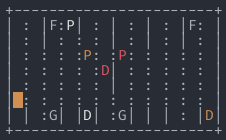

In [ ]:
# observation not wrapped within dictionary
np_to_pil(obs)

In [ ]:
# no need to specify taxi for action meanings / map or any other internal API function
single_taxi_env.unwrapped.get_action_meanings()

{0: 'south',
 1: 'north',
 2: 'east',
 3: 'west',
 4: 'pickup0',
 5: 'pickup1',
 6: 'pickup2',
 7: 'dropoff',
 8: 'standby',
 9: 'refuel'}

In [ ]:
# can use transition function with specific aciton (not joint dictionary action)
single_taxi_env.unwrapped.state_action_transitions(single_taxi_env.state(), 0)

[(<multi_taxi.env.state.MultiTaxiEnvState at 0x169708580>,
  -1,
  False,
  False,
  {'events': [<Event.STEP: 1>, <Event.MOVE: 2>],
   'dead': False,
   'move_success': True,
   'desired_action': 'south',
   'performed_transition': 'south'})]

+-----------------------+
| : |F:P| : | : | : |F: |
| : | : : : | : | : | : |
| : : : :P: :P: : : : : |
| : : : : :D| : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| |D| :G| | | : |D|
+-----------------------+
Taxi0-YELLOW: Fuel: 98/100, Location: (6, 0), Engine: ON, Collided: False, Step: 1, ALIVE
Passenger0-YELLOW: Location: (2, 4), Destination: (6, 11)
Passenger1-RED: Location: (2, 6), Destination: (3, 5)
Passenger2-WHITE: Location: (0, 3), Destination: (6, 4)
Env done: False

reward=-1
term=False
info={'events': [<Event.STEP: 1>, <Event.MOVE: 2>], 'dead': False, 'move_success': True, 'desired_action': 'south', 'performed_transition': 'south'}
obs=


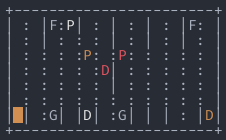

In [ ]:
# step as you would in a gymnasium environment
obs, reward, term, trunc, info = single_taxi_env.step(0)
single_taxi_env.render()

# outputs as expected in gymnasium
print(f'reward={reward}')
print(f'term={term}')
print(f'info={info}')
print('obs=')
np_to_pil(obs)

### Simplifying Wrappers
As we have seen throughout this notebook, this environment can be very complex. One thing that makes it extremely difficult to solve is its ever-changing passenger and destination positions. We implement several wrappers that fix these positions in place. In the example below, we create an environment whose passengers' start locations are always the same. There are also wrappers for fixing the taxi start locations and the passenger destination locations.

In [ ]:
from multi_taxi import wrappers

fixed_passengers_env = multi_taxi_v0.env(
    num_taxis=7,
    num_passengers=7,
    render_mode='human'
)

fixed_passengers_env = wrappers.FixedPassengerStartLocationsWrapper(fixed_passengers_env,
                                                                    # provide sequence row, col, row, col, ...
                                                                    # one pair for each passenger
                                                                    0, 0,
                                                                    0, 1,
                                                                    0, 2,
                                                                    0, 3,
                                                                    0, 4,
                                                                    0, 5,
                                                                    0, 6)

No matter how many times we reset the environment, the passengers will always spawn in their given initial locations. Rerun the cell below multiple times to convince yourself that is the case.

In [ ]:
fixed_passengers_env.reset()
fixed_passengers_env.render()

+-----------------------+
|D:P|P:P|P:P|P: |D: |F: |
| : | : : :D| : | : | :D|
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | :D: : : : |
| : : : : : : : : :D: : |
| | :G| | | :G|D| | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (0, 3), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: inf, Location: (3, 4), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi2-WHITE: Fuel: inf, Location: (5, 5), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi3-GREEN: Fuel: inf, Location: (2, 9), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi4-CYAN: Fuel: inf, Location: (2, 2), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi5-BLUE: Fuel: inf, Location: (1, 11), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi6-MAGENTA: Fuel: inf, Location: (2, 7), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (0, 0), Destination: (1, 11)
Passenger1-RED: Location: (0, 1), Destination: (4, 7)
Passenger2-WHITE: Location: (0, 2), Destination: (6,

There are also wrappers for fixing passenger destinations and taxi locations.

In [ ]:
fixed_everything_env = wrappers.FixedPassengerDestinationsWrapper(fixed_passengers_env,
                                                                  1, 0,
                                                                  1, 1,
                                                                  1, 2,
                                                                  1, 3,
                                                                  1, 4,
                                                                  1, 5,
                                                                  1, 6)
fixed_everything_env = wrappers.FixedTaxiStartLocationsWrapper(fixed_everything_env,
                                                               2, 0,
                                                               2, 1,
                                                               2, 2,
                                                               2, 3,
                                                               2, 4,
                                                               2, 5,
                                                               2, 6)

In [ ]:
fixed_everything_env.reset()
fixed_everything_env.render()

+-----------------------+
|P:P|P:P|P:P|P: | : |F: |
|D:D|D:D:D:D|D: | : | : |
| : : : : : : : : : : : |
| : : : : : | : : : : : |
| : : : : : | : : : : : |
| : : : : : : : : : : : |
| | :G| | | :G| | | : | |
+-----------------------+
Taxi0-YELLOW: Fuel: inf, Location: (2, 0), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi1-RED: Fuel: inf, Location: (2, 1), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi2-WHITE: Fuel: inf, Location: (2, 2), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi3-GREEN: Fuel: inf, Location: (2, 3), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi4-CYAN: Fuel: inf, Location: (2, 4), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi5-BLUE: Fuel: inf, Location: (2, 5), Engine: ON, Collided: False, Step: 0, ALIVE
Taxi6-MAGENTA: Fuel: inf, Location: (2, 6), Engine: ON, Collided: False, Step: 0, ALIVE
Passenger0-YELLOW: Location: (0, 0), Destination: (1, 0)
Passenger1-RED: Location: (0, 1), Destination: (1, 1)
Passenger2-WHITE: Location: (0, 2), Destination: (1, 2

Note that these warppers will override the `allow_collided_taxis_on_reset` and `allow_arrived_passengers_on_reset` parameters since all location sampling rules are completely ignored.